In [1]:
# Importações necessárias
import numpy as np
import math

# Definições iniciais e parâmetros
PI = np.pi
c = 2e-9
Rext  = 30e-9
Rint  = 20e-9
Largo = 900e-9
Theta = PI/100

# Cálculo do raio médio e ângulo de rotação
R = Largo/Theta
dp = 10e-6
ThetaRotz = 0.5*PI - 0.5*Theta

# Cálculo das dimensões do sistema dependendo do ângulo Theta
if Theta <= PI:
    ax = 2*(R+Rext)*np.sin(0.5*Theta)
    ay = (R+Rext) - (R-Rext)*np.cos(0.5*Theta)
    az = 2*Rext
    cx = 0
    cy = 0.5*(R+Rext) + 0.5*(R-Rext)*np.cos(0.5*Theta)
    cz = 0
    pxB = -(-0.5*dp*np.cos(ThetaRotz) + 0.5*dp*np.sin(ThetaRotz))
    pyB = -(0.5*dp*np.sin(ThetaRotz) + 0.5*dp*np.cos(ThetaRotz))
    pxA = -(0.5*dp*np.cos(-ThetaRotz) + 0.5*dp*np.sin(-ThetaRotz))
    pyA = -(-0.5*dp*np.sin(-ThetaRotz) + 0.5*dp*np.cos(-ThetaRotz))
else:
    auxTheta = Theta - PI
    ax = 2*(R+Rext)
    ay = (R+Rext) + (R+Rext)*np.cos(0.5*auxTheta)
    az = 2*Rext
    cx = 0
    cy = 0.5*(R+Rext) - 0.5*(R+Rext)*np.cos(0.5*auxTheta)
    cz = 0

# Cálculo do número de células em cada direção
nx = math.ceil(ax/c)
ny = math.ceil(ay/c)
nz = math.ceil(az/c)

bz  = 2*Rint
nzz = math.ceil(bz/c)

# Parâmetros magnéticos do material
Ms = 800e3
Aex = 13e-12
alpha = 0.5

print(f"Grid size: nx={nx}, ny={ny}, nz={nz}")
print(f"Grid size for inner hole: nzz={nzz}")


Grid size: nx=451, ny=32, nz=30
Grid size for inner hole: nzz=20


In [5]:
# Escreve o arquivo de entrada para Mumax3

filename = 'TesteCorte.mx3'
with open(filename, 'w') as fout:
    fout.write('OutputFormat = OVF2_TEXT\n')
    fout.write(f'SetGridSize({nx},{ny},{nz})\n')
    fout.write(f'SetCellSize({c},{c},{c})\n\n')
    
    fout.write('hilo := cuboid(0.0,0.0,0.0)\n')
    fout.write(f'for i := 1; i <= {nz}; i++ {{\n')
    fout.write(f'    z := -1e-9-(0.5*{nz}-1)*{c}+(i-1)*{c}\n')
    fout.write(f'    hilo = hilo.add(cylinder(2*{R}+2*sqrt({Rext}*{Rext}-z*z),{c}).transl(0,0,z))\n')
    fout.write(f'    hilo = hilo.sub(cylinder(2*{R}-2*sqrt({Rext}*{Rext}-z*z),{c}).transl(0,0,z))\n')
    fout.write('}\n\n')
    
    fout.write('hueco := cuboid(0.0,0.0,0.0)\n')
    fout.write(f'for i := 1; i <= {nzz}; i++ {{\n')
    fout.write(f'    z := -1e-9-(0.5*{nzz}-1)*{c}+(i-1)*{c}\n')
    fout.write(f'    hueco = hueco.add(cylinder(2*{R}+2*sqrt({Rint}*{Rint}-z*z),{c}).transl(0,0,z))\n')
    fout.write(f'    hueco = hueco.sub(cylinder(2*{R}-2*sqrt({Rint}*{Rint}-z*z),{c}).transl(0,0,z))\n')
    fout.write('}\n')
    
    fout.write(f'hilo = hilo.transl({cx},{cy},{cz})\n')
    fout.write(f'hueco = hueco.transl({cx},{cy},{cz})\n')
    fout.write('hilo = hilo.sub(hueco)\n\n')
    
    if Theta <= PI:
        fout.write(f'sq1 := cuboid(10e-6,10e-6,{az}).transl(-5e-6,5e-6,0).rotz({PI-Theta}*0.5)\n')
        fout.write(f'sq1 = sq1.transl({cx},{cy},{cz})\n')
        fout.write(f'sq2 := cuboid(10e-6,10e-6,{az}).transl(5e-6,5e-6,0).rotz({-PI+Theta}*0.5)\n')
        fout.write(f'sq2 = sq2.transl({cx},{cy},{cz})\n')
        fout.write('sq := sq1.add(sq2)\n')
    else:
        fout.write(f'sq1 := cuboid(10e-6,10e-6,{az}).transl(5e-6,5e-6,0).rotz({Theta-PI}*0.5)\n')
        fout.write(f'sq1 = sq1.transl({cx},{cy},{cz})\n')
        fout.write('sq1 = sq1.sub(xrange(-10e-6,0))\n')
        fout.write(f'sq2 := cuboid(10e-6,10e-6,{az}).transl(-5e-6,5e-6,0).rotz({-Theta+PI}*0.5)\n')
        fout.write(f'sq2 = sq2.transl({cx},{cy},{cz})\n')
        fout.write('sq2 = sq2.sub(xrange(0,10e-6))\n')
        fout.write('sq := sq1.add(sq2)\n')
    
    fout.write('hilo = hilo.sub(sq)\n')
    fout.write('setgeom(hilo)\n')
    fout.write('saveas(geom,"initial")\n\n')
    
    fout.write(f'Msat = {Ms}\n')
    fout.write(f'Aex = {Aex}\n')
    fout.write(f'alpha = {alpha}\n\n')
    
    fout.write('m = uniform(1,0,0)\n')
    fout.write('m.setInShape(xrange(-10e-6,0),uniform(-1,0,0))\n')
    fout.write('relax()\n')
    fout.write('save(m)\n')

print(f"Arquivo '{filename}' gerado com sucesso.")


Arquivo 'TesteCorte.mx3' gerado com sucesso.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
plt.style.use(['notebook','grid','science'])

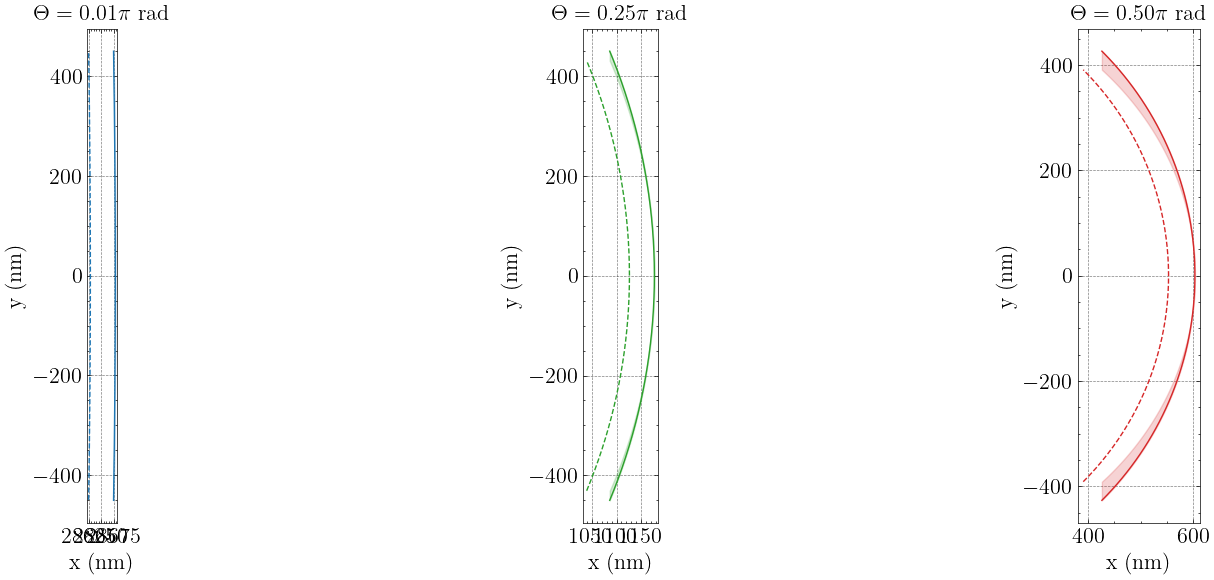

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Definições
PI = np.pi
Rext = 30e-9
Rint = 20e-9
Largo = 900e-9

# Valores de Theta
thetas = [PI/100,PI/4, PI/2, 3*PI/1.54]
colors = ['#1f77b4', '#2ca02c', '#d62728']  # cores para cada Theta

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (Theta, color) in enumerate(zip(thetas, colors)):
    ax = axs[i]
    
    R = Largo/Theta
    
    t = np.linspace(-Theta/2, Theta/2, 200)
    x_ext = (R + Rext) * np.cos(t)
    y_ext = (R + Rext) * np.sin(t)
    x_int = (R - Rint) * np.cos(t)
    y_int = (R - Rint) * np.sin(t)
    
    # Plotar contornos
    ax.plot(x_ext*1e9, y_ext*1e9, color=color, label=r'Raio externo ($R+R_{ext}$)')
    ax.plot(x_int*1e9, y_int*1e9, color=color, linestyle='--', label=r'Raio interno ($R-R_{int}$)')
    
    # Preencher área entre as curvas
    ax.fill_between(x_ext*1e9, y_ext*1e9, y_int*1e9, color=color, alpha=0.2)
    
    # Eixos e estilo
    ax.set_title(r'$\Theta = {:.2f} \pi$ rad'.format(Theta/PI))
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_aspect('equal')
    ax.grid(True)

plt.tight_layout()
#plt.savefig('Arcosseparados.pdf')


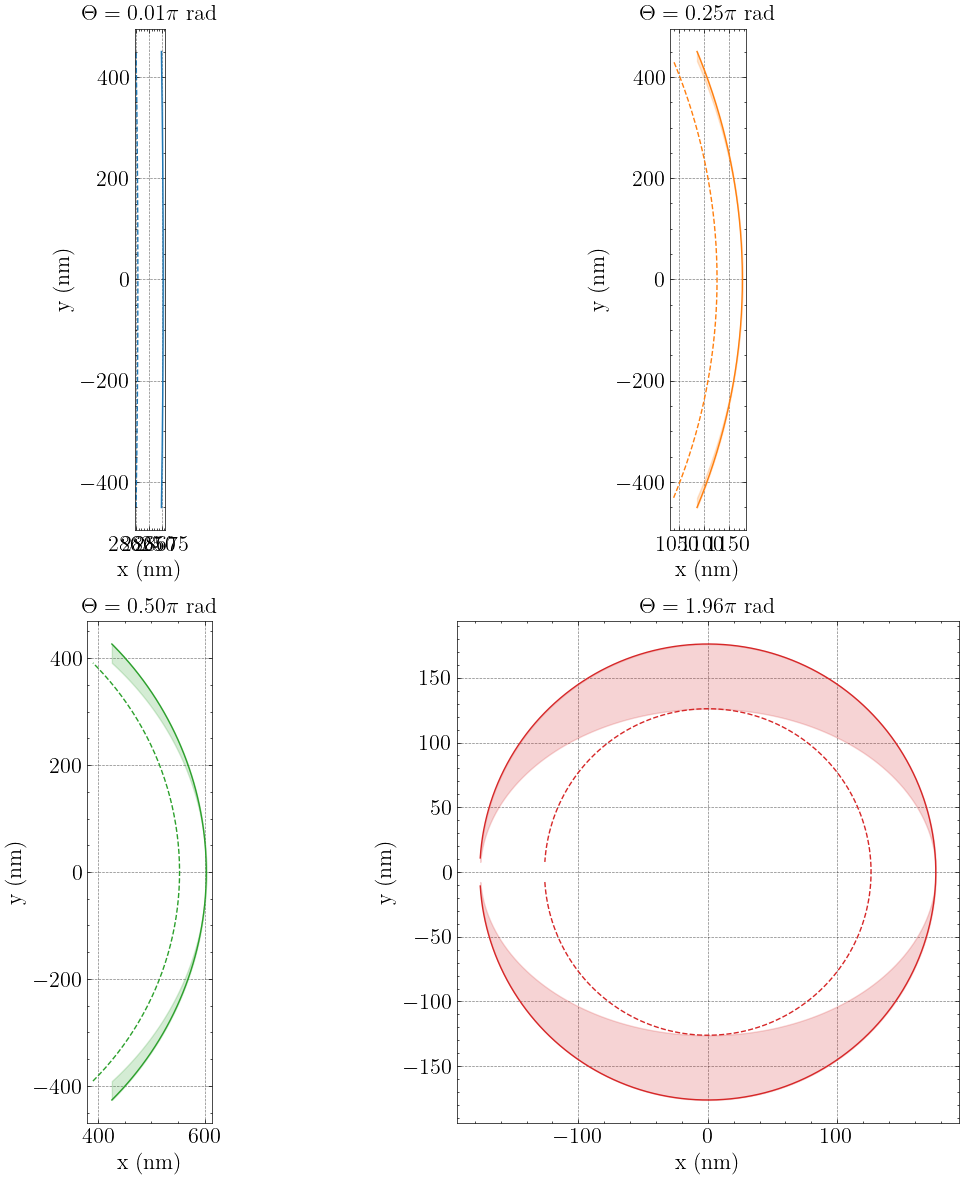

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Definições
PI = np.pi
Rext = 30e-9
Rint = 20e-9
Largo = 900e-9

# Valores de Theta
thetas = [PI/100, PI/4, PI/2, 3*PI/1.53]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, (Theta, color) in enumerate(zip(thetas, colors)):
    ax = axs[i]
    
    R = Largo / Theta
    t = np.linspace(-Theta/2, Theta/2, 200)
    
    x_ext = (R + Rext) * np.cos(t)
    y_ext = (R + Rext) * np.sin(t)
    x_int = (R - Rint) * np.cos(t)
    y_int = (R - Rint) * np.sin(t)
    
    # Plotar contornos
    ax.plot(x_ext * 1e9, y_ext * 1e9, color=color, label=r'Raio externo ($R+R_{ext}$)')
    ax.plot(x_int * 1e9, y_int * 1e9, color=color, linestyle='--', label=r'Raio interno ($R-R_{int}$)')
    
    # Preencher área entre as curvas
    ax.fill_between(x_ext * 1e9, y_ext * 1e9, y_int * 1e9, color=color, alpha=0.2)
    
    # Eixos e estilo
    ax.set_title(r'$\Theta = {:.2f} \pi$ rad'.format(Theta / PI))
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_aspect('equal')
    ax.grid(True)

plt.tight_layout()
plt.show()


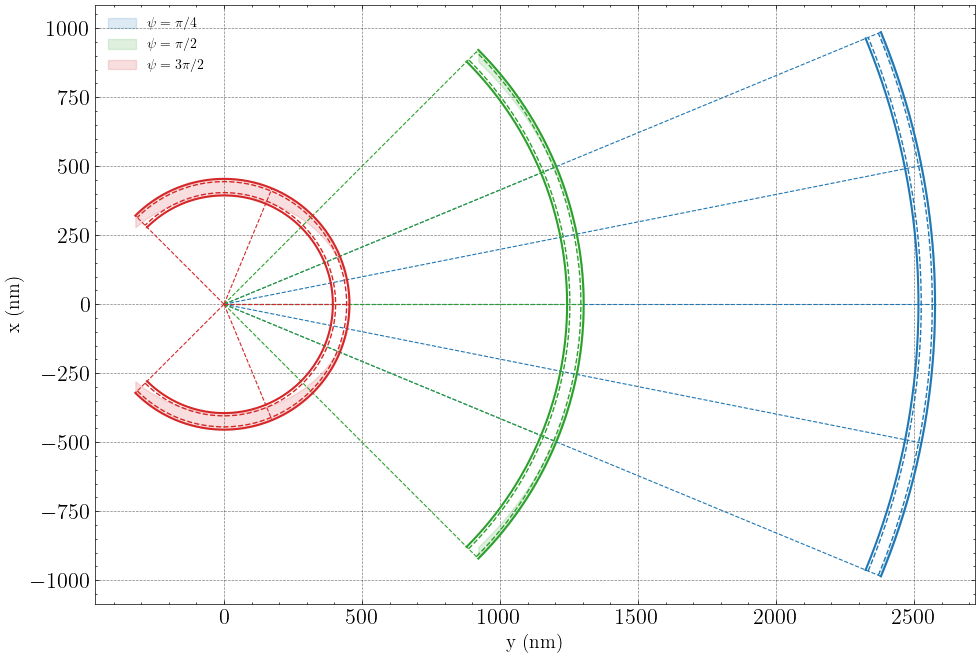

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Definições
PI = np.pi
Rext = 30e-9
Rint = 20e-9
Largo = 2000e-9

# Valores de Theta, cores e rótulos
thetas = [PI/4, PI/2, 3*PI/2]
colors = ['#1f77b4', '#2ca02c', '#d62728']  # azul, verde, vermelho
labels = [r'$\psi = \pi/4$', r'$\psi = \pi/2$', r'$\psi = 3\pi/2$']

# Criar a figura
plt.figure(figsize=(10, 10))

for Theta, color, label in zip(thetas, colors, labels):
    R = Largo / Theta
    t = np.linspace(-Theta/2, Theta/2, 300)
    
    # Raio externo
    x_ext = (R + Rext) * np.cos(t)
    y_ext = (R + Rext) * np.sin(t)
    
    # Raio interno
    x_int = (R - Rext) * np.cos(t)
    y_int = (R - Rext) * np.sin(t)
    
    # Furo (raio interno do tubo)
    x_hueco_ext = (R + Rint) * np.cos(t)
    y_hueco_ext = (R + Rint) * np.sin(t)
    
    x_hueco_int = (R - Rint) * np.cos(t)
    y_hueco_int = (R - Rint) * np.sin(t)
    
    # Preencher a área do tubo
    plt.fill_between(x_ext*1e9, y_ext*1e9, y_int*1e9, color=color, alpha=0.15, label=label)
    
    # Contornos do tubo (externo)
    plt.plot(x_ext*1e9, y_ext*1e9, color=color, linewidth=1.5)
    plt.plot(x_int*1e9, y_int*1e9, color=color, linewidth=1.5)
    
    # Contornos do furo (interno)
    plt.plot(x_hueco_ext*1e9, y_hueco_ext*1e9, color=color, linestyle='--', linewidth=1.0)
    plt.plot(x_hueco_int*1e9, y_hueco_int*1e9, color=color, linestyle='--', linewidth=1.0)
    
    # Linhas rachuradas (raios)
    for ang in np.linspace(-Theta/2, Theta/2, 5):
        plt.plot([0, (R+Rext)*np.cos(ang)*1e9], [0, (R+Rext)*np.sin(ang)*1e9], color=color, linestyle='--', lw=0.8)

# Ajustes do gráfico
plt.xlabel('y (nm)',fontsize=14)
plt.ylabel('x (nm)',fontsize=14)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
#plt.savefig('Arcos.pdf')


In [3]:
import numpy as np
import math

PI = np.pi

#### info
c = 2e-9
Rext  = 30e-9
Rint  = 20e-9
Largo = 2000e-9
Theta = (3*PI)/(1.53)

#### celdas y estructura
R = Largo/Theta
dp = 10e-6
ThetaRotz = 0.5*PI - 0.5*Theta

if Theta <= PI:
    ax = 2*(R+Rext)*np.sin(0.5*Theta)
    ay = (R+Rext)-(R-Rext)*np.cos(0.5*Theta)
    az = 2*Rext
    cx = 0
    cy = 0.5*(R+Rext) + 0.5*(R-Rext)*np.cos(0.5*Theta)
    cz = 0
    pxB = -(-0.5*dp*np.cos(ThetaRotz)+0.5*dp*np.sin(ThetaRotz))
    pyB = -(0.5*dp*np.sin(ThetaRotz)+0.5*dp*np.cos(ThetaRotz))
    pxA = -(0.5*dp*np.cos(-ThetaRotz)+0.5*dp*np.sin(-ThetaRotz))
    pyA = -(-0.5*dp*np.sin(-ThetaRotz)+0.5*dp*np.cos(-ThetaRotz))

else:
    auxTheta = Theta - PI
    ax = 2*(R+Rext)
    ay = (R+Rext) + (R+Rext)*np.cos(0.5*auxTheta)
    az = 2*Rext
    cx = 0
    cy = 0.5*(R+Rext) - 0.5*(R+Rext)*np.cos(0.5*auxTheta)
    cz = 0

nx = math.ceil(ax / c)
ny = math.ceil(ay / c)
nz = math.ceil(az / c)

bz  = 2*Rint
nzz = math.ceil(bz / c)

#### material magnetico
Ms = 800e3
Aex = 13e-12
alpha = 0.5

##################### Escreve Arquivo #####################
fout = open('Teste.mx3', 'w')
fout.write('OutputFormat = OVF2_BINARY\n')
fout.write(f'SetGridSize({nx},{ny},{nz})\n')
fout.write(f'SetCellSize({c},{c},{c})\n\n')

fout.write('hilo := cuboid(0.0,0.0,0.0)\n')
fout.write('for i := 1; i <= '+str(nz)+'; i++ {\n')
fout.write('    z := -1e-9-(0.5*'+str(nz)+'-1)*'+str(c)+'+(i-1)*'+str(c)+'\n')
fout.write('    hilo = hilo.add(cylinder(2*'+str(R)+'+2*sqrt('+str(Rext)+'*'+str(Rext)+'-z*z),'+str(c)+').transl(0,0,z))\n')
fout.write('    hilo = hilo.sub(cylinder(2*'+str(R)+'-2*sqrt('+str(Rext)+'*'+str(Rext)+'-z*z),'+str(c)+').transl(0,0,z))\n')
fout.write('}\n\n')

fout.write('hueco := cuboid(0.0,0.0,0.0)\n')
fout.write('for i := 1; i <= '+str(nzz)+'; i++ {\n')
fout.write('    z := -1e-9-(0.5*'+str(nzz)+'-1)*'+str(c)+'+(i-1)*'+str(c)+'\n')
fout.write('    hueco = hueco.add(cylinder(2*'+str(R)+'+2*sqrt('+str(Rint)+'*'+str(Rint)+'-z*z),'+str(c)+').transl(0,0,z))\n')
fout.write('    hueco = hueco.sub(cylinder(2*'+str(R)+'-2*sqrt('+str(Rint)+'*'+str(Rint)+'-z*z),'+str(c)+').transl(0,0,z))\n')
fout.write('}\n')
fout.write(f'hilo = hilo.transl({cx},{cy},{cz})\n')
fout.write(f'hueco = hueco.transl({cx},{cy},{cz})\n')
fout.write('hilo = hilo.sub(hueco)\n')

if Theta <= PI:
    fout.write('sq1 := cuboid(10e-6,10e-6,'+str(az)+').transl(-5e-6,5e-6,0).rotz('+str(PI-Theta)+'*0.5)\n')
    fout.write(f'sq1 = sq1.transl({cx},{cy},{cz})\n')
    fout.write('sq2 := cuboid(10e-6,10e-6,'+str(az)+').transl(5e-6,5e-6,0).rotz('+str(-PI+Theta)+'*0.5)\n')
    fout.write(f'sq2 = sq2.transl({cx},{cy},{cz})\n')
    fout.write('sq := sq1.add(sq2)\n')

else:
    fout.write('sq1 := cuboid(10e-6,10e-6,'+str(az)+').transl(5e-6,5e-6,0).rotz('+str(Theta-PI)+'*0.5)\n')
    fout.write(f'sq1 = sq1.transl({cx},{cy},{cz})\n')
    fout.write('sq1 = sq1.sub(xrange(-10e-6,0))\n')
    fout.write('sq2 := cuboid(10e-6,10e-6,'+str(az)+').transl(-5e-6,5e-6,0).rotz('+str(-Theta+PI)+'*0.5)\n')
    fout.write(f'sq2 = sq2.transl({cx},{cy},{cz})\n')
    fout.write('sq2 = sq2.sub(xrange(0,10e-6))\n')   
    fout.write('sq := sq1.add(sq2)\n')

fout.write('hilo = hilo.sub(sq)\n')
fout.write('setgeom(hilo)\n')
fout.write('saveas(geom,"initial")\n\n')

fout.write(f'Msat = {Ms}\n')
fout.write(f'Aex = {Aex}\n')
fout.write(f'alpha = {alpha}\n\n')

# Magnetização invertida
fout.write('m = uniform(-1,0,0)\n')
fout.write('m.setInShape(xrange(-10e-6,-10e-6),uniform(1,0,0))\n')
fout.write('relax()\n')
fout.write('save(m)\n')

fout.close()


In [4]:
print(f"Grid size: nx={nx}, ny={ny}, nz={nz}")
print(f"Grid size for inner hole: nzz={nzz}")

Grid size: nx=355, ny=189, nz=30
Grid size for inner hole: nzz=20


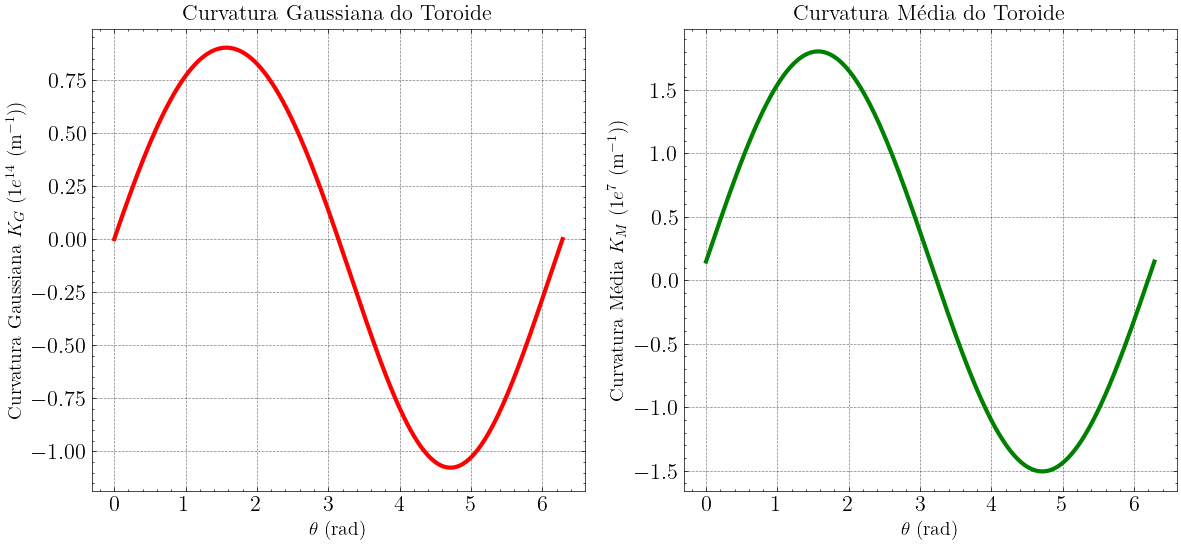

In [8]:
# Parâmetros fornecidos no código
Largo = 2000e-9  # metros
Theta = 3 * np.pi / 1.6  # radianos
Rext = 30e-9  # metros
R = Largo / Theta  # Raio médio
r = Rext  # Raio externo

# Intervalo de valores para theta (0 a 2*pi)
theta = np.linspace(0, 2 * np.pi, 400)

# Cálculo das curvaturas Gaussiana (KG) e Média (KM)
KG = np.sin(theta) / (r * (R + r * np.sin(theta)))  # Curvatura Gaussiana K_G
KM = 0.5 * (np.sin(theta) / r + 1 / (R + r * np.sin(theta)))  # Curvatura Média K_M

# Multiplicando os eixos y conforme solicitado (potência negativa)
KG_scaled_y = KG * 1e-14  # Eixo y da Curvatura Gaussiana multiplicado por 1e-14
KM_scaled_y = KM * 1e-7  # Eixo y da Curvatura Média multiplicado por 1e-7

# Criando os gráficos com as unidades no eixo y
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot da Curvatura Gaussiana com o eixo y multiplicado por 1e-14
ax1.plot(theta, KG_scaled_y, 'r', linewidth=3)
ax1.set_title('Curvatura Gaussiana do Toroide')
ax1.set_xlabel(r'$\theta$ (rad)',fontsize = 14)
ax1.set_ylabel(r'Curvatura Gaussiana $K_G$  ($1e^{14}$ (m$^{-1}$))',fontsize = 14)
ax1.set_ylim([np.min(KG_scaled_y)*1.1, np.max(KG_scaled_y)*1.1])
ax1.grid(True)

# Plot da Curvatura Média com o eixo y multiplicado por 1e-7
ax2.plot(theta, KM_scaled_y, 'g', linewidth=3)
ax2.set_title('Curvatura Média do Toroide')
ax2.set_xlabel(r'$\theta$ (rad)', fontsize = 14)
ax2.set_ylabel(r'Curvatura Média $K_M$ ($1e^{7}$ (m$^{-1}$))', fontsize = 14)
ax2.set_ylim([np.min(KM_scaled_y)*1.1, np.max(KM_scaled_y)*1.1])
ax2.grid(True)

#plt.savefig('KG&KM.pdf')


# Código Novo

In [3]:
import numpy as np
import math

PI = np.pi

#### info
c = 2e-9
Rext  = 30e-9
Rint  = 20e-9
Largo = 4000e-9
Theta = 3*PI/1.9
B = 100e-3

#### celdas y estructura
R = Largo/Theta
dp = 10e-6
ThetaRotz = 0.5*PI-0.5*Theta

if Theta <= PI:
    ax = 2*(R+Rext)*np.sin(0.5*Theta)
    ay = (R+Rext)-(R-Rext)*np.cos(0.5*Theta)
    az = 2*Rext
    cx = 0
    cy = 0.5*(R+Rext)+0.5*(R-Rext)*np.cos(0.5*Theta)
    cz = 0
    pxB = -(-0.5*dp*np.cos(ThetaRotz)+0.5*dp*np.sin(ThetaRotz))
    pyB = -(0.5*dp*np.sin(ThetaRotz)+0.5*dp*np.cos(ThetaRotz))
    pxA = -(0.5*dp*np.cos(-ThetaRotz)+0.5*dp*np.sin(-ThetaRotz))
    pyA = -(-0.5*dp*np.sin(-ThetaRotz)+0.5*dp*np.cos(-ThetaRotz))
    
else:
    auxTheta = Theta-PI
    ax = 2*(R+Rext)
    ay = (R+Rext)+(R+Rext)*np.cos(PI-Theta/2)
    az = 2*Rext
    cx = 0
    cy = 0.5*(2*(R+Rext)-ay)
    cz = 0
    
nxi = math.ceil(ax/c)
nyi = math.ceil(ay/c)
nzi = math.ceil(az/c)

nx = math.ceil(nxi/10) * 10
ny = math.ceil(nyi/10) * 10
nz = math.ceil(nzi/10) * 10


bz  = 2*Rint
nzz = math.ceil(bz/c)

#### material magnetico
Ms = 800e3
Aex = 13e-12
alpha = 0.5

print(f"Grid size: nx={nx}, ny={ny}, nz={nz}")
print(f"Grid size for inner hole: nzz={nzz}")


Grid size: nx=840, ny=750, nz=30
Grid size for inner hole: nzz=20


In [4]:
##################### Escribe Archivo #####################
fout = open('3pi2.mx3','w')
fout.write('OutputFormat = OVF2_TEXT'+'\n')
fout.write('SetGridSize('+str(nx)+','+str(ny)+','+str(nz)+')'+'\n')
fout.write('SetCellSize('+str(c)+','+str(c)+','+str(c)+')'+'\n')
fout.write('\n')
fout.write('hilo := cuboid(0.0,0.0,0.0)')
fout.write('\n')
fout.write('for i := 1; i <= '+str(nz)+'; i++ {'+'\n')
fout.write('    z := -1e-9-(0.5*'+str(nz)+'-1)*'+str(c)+'+(i-1)*'+str(c)+'\n')
fout.write('    hilo = hilo.add(cylinder(2*'+str(R)+'+2*sqrt('+str(Rext)+'*'+str(Rext)+'-z*z),'+str(c)+').transl(0,0,z))'+'\n')
fout.write('    hilo = hilo.sub(cylinder(2*'+str(R)+'-2*sqrt('+str(Rext)+'*'+str(Rext)+'-z*z),'+str(c)+').transl(0,0,z))'+'\n')
fout.write('}'+'\n')
fout.write('\n')
fout.write('hueco := cuboid(0.0,0.0,0.0)'+'\n')
fout.write('for i := 1; i <= '+str(nzz)+'; i++ {'+'\n')
fout.write('    z := -1e-9-(0.5*'+str(nzz)+'-1)*'+str(c)+'+(i-1)*'+str(c)+'\n')
fout.write('    hueco = hueco.add(cylinder(2*'+str(R)+'+2*sqrt('+str(Rint)+'*'+str(Rint)+'-z*z),'+str(c)+').transl(0,0,z))'+'\n')
fout.write('    hueco = hueco.sub(cylinder(2*'+str(R)+'-2*sqrt('+str(Rint)+'*'+str(Rint)+'-z*z),'+str(c)+').transl(0,0,z))'+'\n')
fout.write('}'+'\n')
fout.write('hilo = hilo.transl('+str(cx)+','+str(cy)+','+str(cz)+')'+'\n')
fout.write('hueco = hueco.transl('+str(cx)+','+str(cy)+','+str(cz)+')'+'\n')
fout.write('hilo = hilo.sub(hueco)'+'\n')

if Theta <= PI:
    fout.write('sq1 := cuboid(10e-6,10e-6,'+str(az)+').transl(-5e-6,5e-6,0).rotz('+str(PI-Theta)+'*0.5)'+'\n')
    fout.write('sq1 = sq1.transl('+str(cx)+','+str(cy)+','+str(cz)+')'+'\n')
    fout.write('sq2 := cuboid(10e-6,10e-6,'+str(az)+').transl(5e-6,5e-6,0).rotz('+str(-PI+Theta)+'*0.5)'+'\n')
    fout.write('sq2 = sq2.transl('+str(cx)+','+str(cy)+','+str(cz)+')'+'\n')
    fout.write('sq := sq1.add(sq2)'+'\n')

else:
    fout.write('sq1 := cuboid(10e-6,10e-6,'+str(az)+').transl(5e-6,5e-6,0).rotz('+str(Theta-PI)+'*0.5)'+'\n')
    fout.write('sq1 = sq1.transl('+str(cx)+','+str(cy)+','+str(cz)+')'+'\n')
    fout.write('sq1 = sq1.sub(xrange(-10e-6,0))'+'\n')
    fout.write('sq2 := cuboid(10e-6,10e-6,'+str(az)+').transl(-5e-6,5e-6,0).rotz('+str(-Theta+PI)+'*0.5)'+'\n')
    fout.write('sq2 = sq2.transl('+str(cx)+','+str(cy)+','+str(cz)+')'+'\n')
    fout.write('sq2 = sq2.sub(xrange(0,10e-6))'+'\n')
    fout.write('sq := sq1.add(sq2)'+'\n')

fout.write('hilo = hilo.sub(sq)'+'\n')
fout.write('setgeom(hilo)'+'\n')
fout.write('\n')
fout.write('Msat = '+str(Ms)+'\n')
fout.write('Aex = '+str(Aex)+'\n')
fout.write('alpha = '+str(alpha)+'\n')
fout.write('\n')
fout.write('m.loadfile("test-initial.out/initial.ovf")'+'\n')
fout.write('tableadd(E_total)'+'\n')
fout.write('tableadd(E_exch)'+'\n')
fout.write('tableadd(E_demag)'+'\n')
fout.write('relax()'+'\n')
fout.write('tablesave()'+'\n')
fout.write('save(m)'+'\n')
fout.close()
